<a href="https://colab.research.google.com/github/UzairYasin/agentic_ai_projects/blob/main/text_analysis_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet langchain langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install -q -U google-generativeai

In [4]:
!pip install --quiet -U langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install python-dotenv

**Importing required libraries**

In [6]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
from google.colab import userdata
import os

In [7]:
os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

In [8]:
class State(TypedDict):
  text: str
  classification: str
  entities: List
  summary: str


llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=os.environ['GOOGLE_API_KEY'],
    temperature=0
    )

In [9]:
def classification_node(state: State):
  ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="""
      Classify the following text into one of the following categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"""
  )
  # Ensure prompt.format returns a string by casting to str if needed
  message_content = prompt.format(text=state['text'])
  # The original code used isinstance and str, but f-strings are better for formatting
  if isinstance(message_content, tuple):
      message_content = f"""
      Classify the following text into one of the following categories: News, Blog, Research, or Other.\n\nText:{state['text']}\n\nCategory:"""

  message = HumanMessage(content=message_content)
  classification = llm.invoke([message]).content.strip()
  return {'classification': classification}

def entity_extraction_node(state: State):
  ''' Extract entities from the text '''
  prompt = PromptTemplate(
  input_variables=["text"],
  template="""
  Extract entities from the following text.\n\nText:{text}\n\nEntities:"""
  )
  # Ensure prompt.format returns a string by casting to str if needed
  message_content = prompt.format(text=state['text'])
  # The original code used isinstance and str, but f-strings are better for formatting
  if isinstance(message_content, tuple):
      message_content = f"""
      Extract entities from the following text.\n\nText:{state['text']}\n\nEntities:"""
  message = HumanMessage(content=message_content)
  entities = llm.invoke([message]).content.strip()
  return {'entities': entities}

def summary_node(state: State):
  ''' Summarize the text '''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="""
      Summarize the following text.\n\nText:{text}\n\nSummary:"""
  )
  # Ensure prompt.format returns a string by casting to str if needed
  message_content = prompt.format(text=state['text'])
    # The original code used isinstance and str, but f-strings are better for formatting
  if isinstance(message_content, tuple):
      message_content = f"""
      Summarize the following text.\n\nText:{state['text']}\n\nSummary:"""
  message = HumanMessage(content=message_content)
  summary = llm.invoke([message]).content.strip()
  return {'summary': summary}

In [10]:
workflow = StateGraph(State)

workflow.add_node('classification1', classification_node)
workflow.add_node('entities1', entity_extraction_node)
workflow.add_node('summary1', summary_node)

workflow.set_entry_point('classification1')
workflow.add_edge('classification1', 'entities1')
workflow.add_edge('entities1', 'summary1')
workflow.add_edge('summary1', END)

app = workflow.compile()

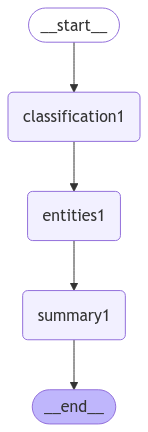

In [11]:
graph = display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
            )))

In [12]:
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {'text': sample_text}

result = app.invoke(state_input)
print("Classification: ", result['classification'])
print("Entities: ", result['entities'])
print("Summary: ", result['summary'])



Classification:  News
Entities:  Here's a breakdown of the entities in the text, categorized for clarity:

**Organization:**

* OpenAI

**Product/Model:**

* GPT-4
* GPT-3

**Technology/Concept:**

* large multimodal model
* AI systems


**Time:**

* coming months


There are no clear Person entities mentioned.  The text focuses on the product and its development.
Summary:  OpenAI's new GPT-4 model is a large, multimodal AI system showing human-level performance on many professional tests.  Designed for improved safety and efficiency compared to GPT-3, it will be publicly released for research and development in the coming months.
